In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append('..')

import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c
from py21cmfast import plotting, cache_tools

print(f'Using 21cmFAST version {p21c.__version__}')
if os.environ['USER'] == 'yitians' and 'submit' in os.uname().nodename:
    p21c.config['direc'] = '/scratch/submit/ctp/yitians/21cmFAST-cache'
p21c.global_params.ZPRIME_STEP_FACTOR= 1.05

Using 21cmFAST version 0.1.dev1578+g6f96f89.d20230216


/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [3]:
from dm21cm.common import get_circle_seq_at

## 1. Test run

In [4]:
cache_tools.clear_cache()

2023-02-20 12:31:06,463 | INFO | Removing InitialConditions_2eda6b944366038a89d6590f0449374d_r54321.h5
2023-02-20 12:31:06,500 | INFO | Removed 1 files from cache.


In [5]:
# initialize
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 50, "BOX_LEN": 50},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321, write=True
)

# redshift
# in DarkHistory: rs = 1 + z
end_z = 20 # set some low threshold
z_arr = [end_z]

while np.amax(z_arr) < p21c.global_params.Z_HEAT_MAX:
    prev_z = (1 + np.amax(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
    z_arr.append(prev_z)
    
z_arr = np.array(z_arr[::-1][1:][:10]) # only do 10 steps
print(z_arr)

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "


[34.91712652 33.20678716 31.57789254 30.02656432 28.54910888 27.14200845
 25.80191281 24.52563125 23.310125   22.1525    ]


In [6]:
Tk_box_arr = []

for i_z, z in enumerate(z_arr):
    
    print(f'i_z={i_z} 1+z={1+z:.3f}')
    
    # input
    input_heating = p21c.input_heating(redshift=z, init_boxes=initial_conditions, write=False)
    input_ionization = p21c.input_ionization(redshift=z, init_boxes=initial_conditions, write=False)
    input_jalpha = p21c.input_jalpha(redshift=z, init_boxes=initial_conditions, write=False)

    input_heating.input_heating += get_circle_seq_at(50, 3, i_z)
    input_ionization.input_ionization += get_circle_seq_at(50, 5, 9-i_z) * 1e-3
    
    # perturbed_field to control redshift
    perturbed_field = p21c.perturb_field(redshift=z, init_boxes=initial_conditions)
    
    # calculate spin temperature
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=(None if i_z==0 else spin_temp),
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        write=True
    )
    Tk_box_arr.append(spin_temp.Tk_box)

i_z=0 1+z=35.917


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=1 1+z=34.207


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=2 1+z=32.578


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=3 1+z=31.027


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=4 1+z=29.549


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=5 1+z=28.142


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=6 1+z=26.802


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=7 1+z=25.526


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=8 1+z=24.310


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation
i_z=9 1+z=23.153


The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']


Just Before Box Evaluation


### view result

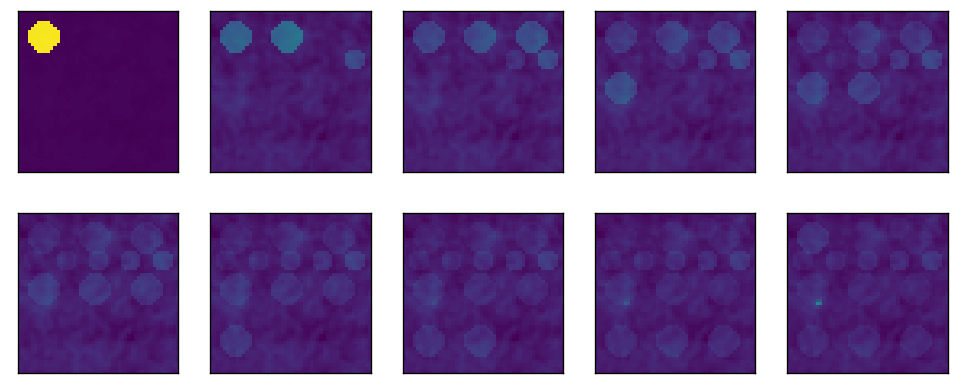

In [7]:
vmax = np.max(Tk_box_arr)

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(Tk_box_arr[i*5+j][25], vmax=vmax)
        axs[i,j].set(xticks=[], yticks=[])

In [8]:
ionized_box = p21c.ionize_box(
    spin_temp = spin_temp,
)

The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
The followin

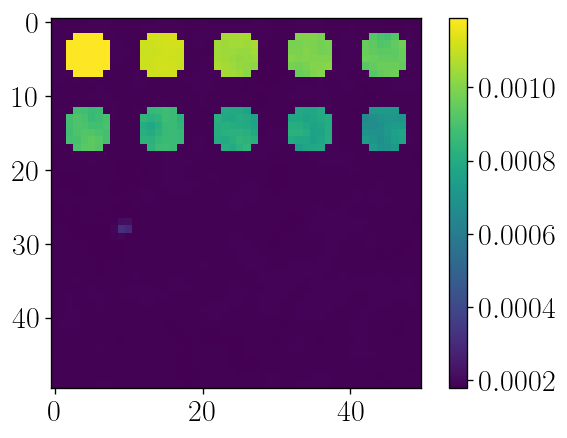

In [9]:
fig, ax = plt.subplots()
im = ax.imshow(1-ionized_box.xH_box[25])
fig.colorbar(im, ax=ax)

## Archive

[Text(0.5, 1.0, 'input ionization'), [], []]

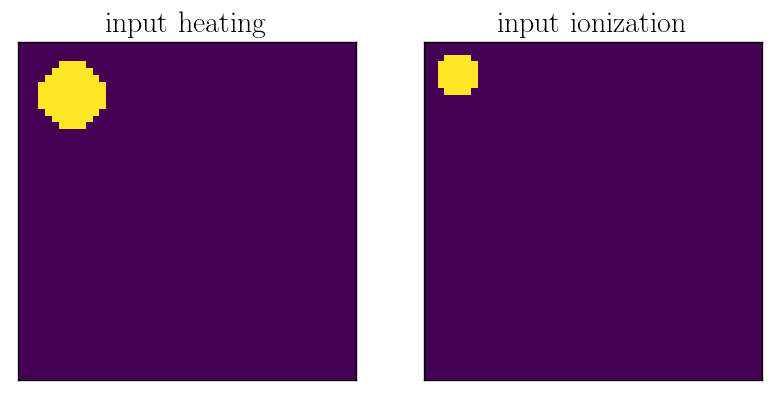

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
im0 = axs[0].imshow(input_heating.input_heating[25])
im1 = axs[1].imshow(input_ionization.input_ionization[25])

axs[0].set(title=r'input heating', xticks=[], yticks=[])
axs[1].set(title=r'input ionization', xticks=[], yticks=[])

#fig.colorbar(im0, ax=axs[0], orientation='horizontal')
#fig.colorbar(im1, ax=axs[1], orientation='horizontal')

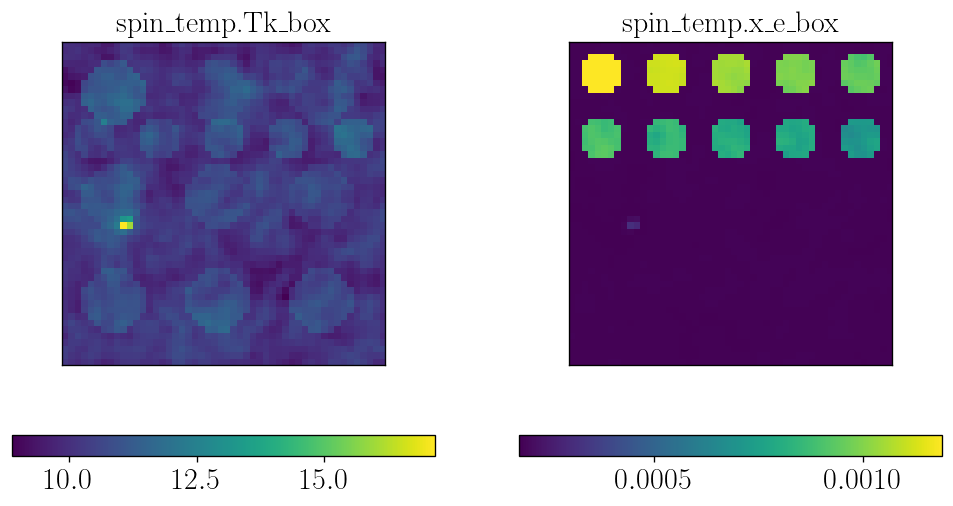

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im0 = axs[0].imshow(spin_temp.Tk_box[25])
im1 = axs[1].imshow(spin_temp.x_e_box[25])

axs[0].set(title='spin_temp.Tk_box', xticks=[], yticks=[])
axs[1].set(title='spin_temp.x_e_box', xticks=[], yticks=[])

fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')